
# spine recognition example using CNN

* filetype : .npy
* filecontent: [imageslist,labelslist,imageshape]
* imageslist: [img1,img2,...]
* labelslist: [0,1,1,0,...] 0:nospine 1:spine
* imageshape: img1.shape 

> Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
import os
import sys
from collections import Counter
from time import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

sys.path.append("..")
import tensorflow as tf
from sklearn.utils import shuffle

from networks.cnn import CNN
from utils.file_base import file_list

gpus = tf.config.experimental.list_physical_devices('GPU')

# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)
# import sys
# print(sys.version)
# print(sys.version_info)
#print(sys.path)

c:\Users\ZLY\AppData\Local\Programs\Python\Python38\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [4]:

model=CNN(2)
model.build(input_shape=(None,16,16,1))
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  800       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  2320      
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  16400     
                                                                 
 dense_1 (Dense)             multiple                  34        
                                                               

In [9]:

def load(f):
    """load single npy"""
    dictl=np.load(f,allow_pickle=True)
    imgs,lables,size=dictl[0],dictl[1],dictl[2]
    
    # introspect the images arrays to find the shapes (for plotting)
    n_samples, h, w = len(imgs),imgs[0].shape[0],imgs[0].shape[1]
    X = np.array([np.array(img).ravel() for img in imgs])
    n_features = h*w
    y = np.array(lables,dtype=np.int8).ravel()
    return X,y,h,w
def loads(fs):
    """load multi npys"""
    XX,yy=None,None
    for f in fs:
        X2,y2,h,w=load(f)
        if XX is not None:
            XX=np.concatenate((XX,X2),axis=0)
            yy=np.concatenate((yy,y2),axis=0)
        else:
            XX=X2
            yy=y2
    label_num= list(np.unique(yy)).sort()
    return XX,yy,label_num,h,w
def mask_balance(XX,yy):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(XX, yy)
    print(sorted(Counter(y_resampled).items()))
    return X_resampled,y_resampled
def reshape_data(XX):
    X=[]
    for x in XX:
        # x=filters.sobel(x)
        x=x.reshape(16,16,1)
        x=x.astype(np.float32)
        X.append(x)
    print("img shape :",X[0].shape)
    return np.array(X)

def split_data(XX,yy):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
    )
    print("Tran num ",len(y_train),"Test num ",len(y_test))
    return X_train, X_test, y_train, y_test
def show_lable_distribution(Ys,lables=None):
    cols=len(Ys)
    fig, axs = plt.subplots(ncols=cols, figsize=(10, 5))
    fig.suptitle(" partion class for dataset")
    autopct = "%.2f"
    for ax,y in zip(axs,Ys):
        def absolute_value(val):
            a  = np.round(val/100*y.shape[0], 0)
            return str(np.round(val,2))+"% : "+str(a)
        yn,ns=np.unique(y,return_counts=True)
        if lables:
            ax.pie(ns,labels=lables,counterclock=True,autopct =absolute_value)
        else:
            ax.pie(ns,labels=yn,counterclock=True,autopct = absolute_value)

#show predict result
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
def title(y_pred, y_test,y_p, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s \nprob: %.2f" % (pred_name, true_name,y_p[i,1])


set dataset directory which include .npy files.

In [7]:
# set dataset directory
TRAINDIR=r"G:\LHJ_DATA\Train\npylable2"
checkponit_save_path= r"D:\spine\segment\some_analysis_for_spine_img\ipynb\model\temp\variables\variables"
SAVE_model_path=r"D:\code\myspine\models\unet_model"

load dataset from : 
	 G:\LHJ_DATA\Train\npylable2\0319.npy
	G:\LHJ_DATA\Train\npylable2\0319_decon.npy
	G:\LHJ_DATA\Train\npylable2\20200724-1.npy
	G:\LHJ_DATA\Train\npylable2\20200808-2.npy
	G:\LHJ_DATA\Train\npylable2\202111-1.npy
	G:\LHJ_DATA\Train\npylable2\20211111-2.npy
	G:\LHJ_DATA\Train\npylable2\20211119-1.npy
[(0, 972), (1, 972)]
img shape : (16, 16, 1)
Tran num  1458 Test num  486


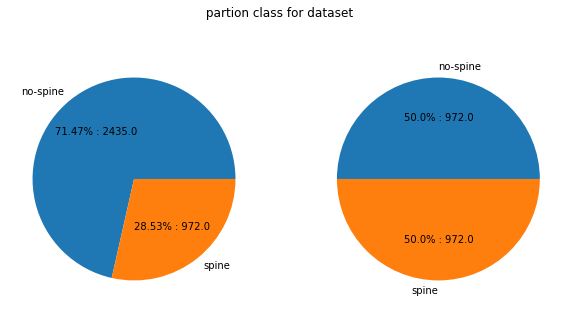

In [10]:
# load dataset
fs=file_list(TRAINDIR,"npy")
print("load dataset from : \n\t","\n\t".join(fs))
XX,yy,label_nums,h,w=loads(fs)
X,y=mask_balance(XX,yy)
X,y=shuffle(X,y)
X=reshape_data(X)
class_names=["no-spine","spine"]
show_lable_distribution([yy,y],class_names)
X_train, X_test, y_train, y_test=split_data(X,y)

In [6]:
#trian
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
vadataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset=dataset.shuffle(1000).batch(8)
vadataset=vadataset.shuffle(1000).batch(8)

if os.path.exists(checkponit_save_path+".index"):
    print("------------load the model -------------")
    model.load_weights(checkponit_save_path)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(dataset, epochs=50,validation_data=vadataset)

Epoch 1/50
183/183 [==============================] - 2s 6ms/step - loss: 6.7193 - sparse_categorical_accuracy: 0.5562 - val_loss: 7.3824 - val_sparse_categorical_accuracy: 0.5144
Epoch 2/50
183/183 [==============================] - 1s 4ms/step - loss: 6.7681 - sparse_categorical_accuracy: 0.5610 - val_loss: 6.1158 - val_sparse_categorical_accuracy: 0.5967
Epoch 3/50
183/183 [==============================] - 1s 4ms/step - loss: 6.7903 - sparse_categorical_accuracy: 0.5604 - val_loss: 5.6881 - val_sparse_categorical_accuracy: 0.6296
Epoch 4/50
183/183 [==============================] - 1s 4ms/step - loss: 5.9358 - sparse_categorical_accuracy: 0.6104 - val_loss: 5.7398 - val_sparse_categorical_accuracy: 0.6255
Epoch 5/50
183/183 [==============================] - 1s 4ms/step - loss: 5.9156 - sparse_categorical_accuracy: 0.6104 - val_loss: 6.3696 - val_sparse_categorical_accuracy: 0.5782
Epoch 6/50
183/183 [==============================] - 1s 4ms/step - loss: 5.5335 - sparse_categorica

In [8]:
# save model
tf.keras.models.save_model(model, SAVE_model_path,save_format='tf')
# model.save(SAVE_model_path,save_format='tf')
#model.save_weights(SAVE_model_path+"\\adasd.h5")

INFO:tensorflow:Assets written to: model/temp\assets


INFO:tensorflow:Assets written to: model/temp\assets


In [9]:
#load model
lmodel=tf.keras.models.load_model(
   SAVE_model_path, custom_objects=None, compile=True, options=None
)
#lmodel.load_weights(SAVE_model_path+"\\adasd.h5")

16/16 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

    no-spine       0.50      0.00      0.01       227
       spine       0.53      1.00      0.69       259

    accuracy                           0.53       486
   macro avg       0.52      0.50      0.35       486
weighted avg       0.52      0.53      0.37       486



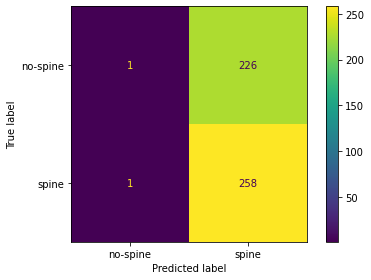

In [11]:
y_p=lmodel.predict(X_test)
y_pred=y_p.argmax(axis=-1)
# print(y_test-y_pred)
# print(X.shape)
print(classification_report(y_test, y_pred, target_names=class_names))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=class_names, xticks_rotation="horizontal"
)
plt.tight_layout()
plt.show()
# lmodel.summary()


In [ ]:
prediction_titles = [
    title(y_pred, y_test,y_p, class_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, 16, 16,8,8)